In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from math import ceil,floor

random_seed = 58
n_class = 2

<p>Here's the description from the paper</p>
<img src="newEEGNet.png" style="width: 700px; float:left;">

In [ ]:
class EEGNet(nn.Module):
    def __init__(self, n_channel , timestamps, F1, sample_rate, D, dropout_prob, n_class):
        super(EEGNet, self).__init__()
        self.dropout_prob = dropout_prob
        self.n_class = n_class
        self.D = D
        self.F1 = F1
        self.timestamps = timestamps
        
        # Block 1
        # nn.Conv2d(in_channels, out_channels, kernel_size)
        #padding to implement mode = 'same'
        self.padding_1 = nn.ZeroPad2d((sample_rate//4-1, sample_rate//4, 0, 0))
        self.conv_1 = nn.Conv2d(1, F1, (1, sample_rate//2))
        self.batchnorm_1 = nn.BatchNorm2d(F1, False)
        self.depthwise_1 = nn.Conv2d(F1, D*F1, (n_channel,1), groups=F1)
        self.batchnorm_2 = nn.BatchNorm2d(D*F1, False)
        
        # to reduce the sampling rate of the signal from 128 to 32
        self.avgpool_1 = nn.AvgPool2d(1,8)
        # Dropout
        
        #Block 2
        
        #Depthwise separable 2D convolution: Separable convolutions consist in first performing a depthwise spatial convolution
        #(which acts on each input channel separately) followed by a pointwise convolution 
        #which mixes together the resulting output channels.
        self.padding_2 = nn.ZeroPad2d((sample_rate//16-1, sample_rate//16, 0, 0))
        self.seperate_1 = nn.Conv2d(D*F1, D*F1, (1, sample_rate//8),groups=F1*D,bias=False)
        self.seperate_2 = nn.Conv2d(D*F1, D*F1, 1,bias=False)
        
        self.batchnorm_3 = nn.BatchNorm2d(D*F1, False)
        self.avgpool_2 = nn.AvgPool2d(1,8)

        #FC Layer
        self.fc1 = nn.Linear(4*13,n_class)
        
    def forward(self, x):
        
        #Block 1
        x = self.padding_1(x)
        x = self.conv_1(x)
        x = self.batchnorm_1(x)
        
        x = self.depthwise_1(x)
        
        x = self.batchnorm_2(x)
        
        x = F.elu(x)
        x = self.avgpool_1(x)
        x = F.dropout(x, self.dropout_prob)
        
        # Block 2
        x = self.padding_2(x)
        
        x = self.seperate_1(x)
        x = self.seperate_2(x)
        #print (x.shape)
        x = self.batchnorm_3(x)
        
        x = F.elu(x)

        x = self.avgpool_2(x)
        
        x = F.dropout(x, self.dropout_prob)
        
        
        #FC Layer
        # 16 depends on x.size()
        #print (x.shape)
        x = x.view(-1,4*13)
        # sigmoid for binary; softmax for multi classes
        x = F.softmax(self.fc1(x),dim = 1)
        
        return x       
        

In [66]:
model = EEGNet(n_channel = 59 , timestamps=800, F1=4, sample_rate=100, D=1, dropout_prob=0.25, n_class=n_class)
a = torch.Tensor(np.random.rand(1, 1, 59, 800))
outputs = model(a)
print (outputs)

tensor([[0.3608, 0.6392]], grad_fn=<SoftmaxBackward>)


In [50]:
def evaluate(model, X, Y, params):
    results = []
    batch_size = 64
    
    predicted = []
    
    for i in range(ceil(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    outputs = model(inputs) 
    #predicted = predicted.data.cpu().numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(outputs.detach().cpu().numpy(),axis = 1)))
#         if param == "recall":
#             results.append(recall_score(Y, np.round(predicted)))
#         if param == "precision":
#             results.append(precision_score(Y, np.round(predicted)))
        if param == "f1":
            results.append(f1_score(Y, np.argmax(outputs.detach().cpu().numpy(),axis = 1)))
    return results

In [51]:
# #(#samples, 1, #channel,timeseries)
#X_train = np.random.rand(134, 1, 59, 8000).astype('float32') # np.random.rand generates between [0, 1)
#Y_train = np.round(np.random.rand(134,n_class).astype('float32')) # binary data, so we round it to 0 or 1.

# X_val = np.random.rand(100, 1, 64, 120).astype('float32')
# y_val = np.round(np.random.rand(100,n_class).astype('float32'))

# X_test = np.random.rand(100, 1, 64, 120).astype('float32')
# y_test = np.round(np.random.rand(100,n_class).astype('float32'))

In [52]:
import scipy.io
from numpy import newaxis
from os import listdir
from os.path import isfile, join
#mypath = './data/BCICIV_1_mat_100HZ_calib/'
def Process_Data(mypath):
    data = []
    Y  = []
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    for d in datafiles:   
        if d == ".DS_Store": 
            continue

        mat = scipy.io.loadmat(mypath+d)
        MrkPos= np.array(mat['mrk'][0,0][0])
        MrkLable = np.array(mat['mrk'][0,0][1])
        Raw_Data = np.array(mat['cnt']).T

        # calculate time duration for each EEG
        Time_diff = []
        for i in range(1,MrkPos.shape[1]):
            Time_diff.append(MrkPos[0,i] - MrkPos[0,i-1])

        #parsing Data

        for i in range(1,MrkPos.shape[1]):
            if (MrkPos[0,i] - MrkPos[0,i-1] == 800):
                tmp_sample = Raw_Data[newaxis, :, MrkPos[0,i-1]:MrkPos[0,i]]
                data.append(tmp_sample)
                if (MrkLable[0,i] == -1):
                    Y.append(0)
                else:
                    Y.append(1)

    #append 3-D samples to 4-D (#samples, 1, #timepoints, #channels) 
    X_train = np.concatenate([arr[np.newaxis] for arr in data]).astype('float32') 
    Y_train = np.array(Y).reshape(-1).astype('float32')
    return X_train,Y_train;


In [44]:
X,Y = Process_Data('./data/BCICIV_1_mat_100HZ_calib/') 
np.random.shuffle(X)
np.random.shuffle(Y)

In [58]:
import matplotlib.pyplot as plt
X_tmp = X[0,0,:,:]
X_tmp.shape

(59, 800)

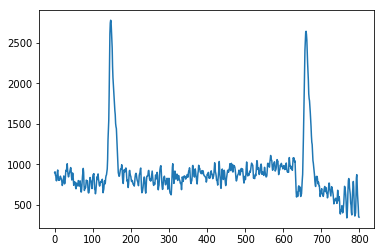

In [65]:
plt.plot(X_tmp[1,:])
plt.show()

In [46]:
#X_val,Y_val = Process_Data('./data/BCICIV_1_mat_100HZ_calib/')

X_train = X[0:900]
Y_train = Y[0:900]

X_test = X[901:]
Y_test = Y[901:]

In [47]:
X_train.shape

(900, 1, 59, 800)

In [53]:
from sklearn.metrics import f1_score
import os
batch_size = 64
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(5):  # loop over the dataset multiple times
    print ("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(ceil(len(X_train)/batch_size)-1):
        #print ("Batch ", i)
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.LongTensor(Y_train[s:e].T)
        #labels = Y_train[:,s:e].reshape(-1)

        # wrap them in Variable
        #inputs, labels = Variable(inputs), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        #print("output ",outputs.size(),"labels ",labels.size())
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()
    
    # Validation accuracy
    params = ["f1","acc"]
    print (params)
    print ("Training Loss ", running_loss)
    #print ("Train - ", evaluate(model, X_train, Y_train, params))
    print ("Validation - ", evaluate(model, X_test, Y_test, params))
    torch.save(model.state_dict(), os.path.join('./model/', 'EEGNet-model-{}.pth'.format(epoch)))


Epoch  0
['f1', 'acc']
Training Loss  9.81405484676361
Validation -  [0.6189473684210526, 0.4958217270194986]

Epoch  1
['f1', 'acc']
Training Loss  9.792078673839569
Validation -  [0.6297872340425531, 0.5153203342618384]

Epoch  2
['f1', 'acc']
Training Loss  9.715118825435638
Validation -  [0.6608695652173914, 0.5654596100278552]

Epoch  3
['f1', 'acc']
Training Loss  9.718465447425842
Validation -  [0.6059225512528473, 0.5181058495821727]

Epoch  4
['f1', 'acc']
Training Loss  9.668500423431396
Validation -  [0.5625000000000001, 0.49303621169916434]


In [ ]:
#     model.eval()
#     y_pred = np.array([])
#     y_true = np.array([])
#     inputs = torch.from_numpy(X_val)
#     labels = torch.FloatTensor(np.array([y_val]).T)
        
#     # wrap them in Variable
#     inputs, labels = Variable(inputs), Variable(labels)
#     outputs = model(inputs)
    

#     y_pred = np.append(y_pred, outputs.detach().numpy().reshape(-1))
#     y_true = np.append(y_true, labels.numpy().reshape(-1))
    
    #print(y_pred.size,y_true.size)
    #print("Dev F1: ", f1_score(y_true, y_pred, average='macro'))
    #f1s.append(f1_score(y_true, y_pred, average='macro'))

In [ ]:
# timepoint = np.array([MrkPos[0,i]-MrkPos[0,i-1] for i in range(1,MrkPos.shape[1])])
# timepoint = np.reshape(timepoint, (-1, len(timepoint)))
# timepoint = np.insert(timepoint,0,MrkPos[0,0],axis =1)
